<a href="https://colab.research.google.com/github/ValentinaPasqual/mythLOD_for_KOCH/blob/main/from_csv_to_rdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>FIRST FIRST THING: WHAT ARE WE DOING?</b>

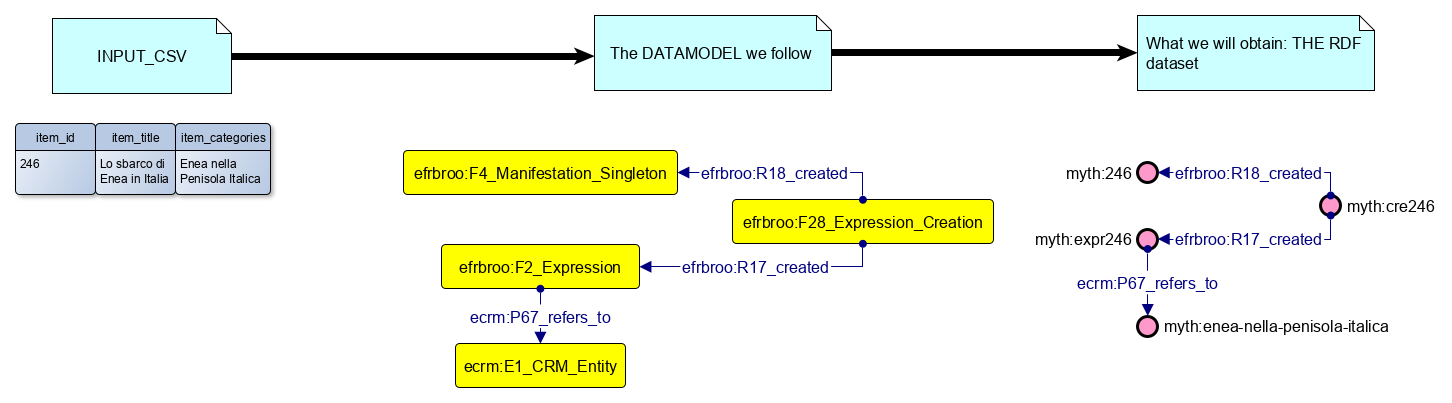

First of all we need to install the python package to transform csv into rdf

In [35]:
!pip install rdflib
!pip install pandas

Mount the drive, follow the link and copy-paste it here below (do not care much about it works)

In [36]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After installing the package and the import modules

In [37]:
from rdflib import Graph, Literal, RDF, URIRef, Namespace # basic RDF handling
from rdflib.namespace import FOAF , XSD, RDF, RDFS # most common namespaces
import pandas as pd

In [38]:
input_data = pd.read_csv('https://raw.githubusercontent.com/ValentinaPasqual/mythLOD_for_KOCH/main/example.csv', sep=';')  # the dataset can be found on my Github

In [39]:
def process_data(source_csv_file_path):
    import csv
    data = list()
    with open(source_csv_file_path, 'r', encoding='utf-8') as test:
        processed_data = csv.DictReader(test, delimiter=';')
        for x in processed_data:
            x = dict(x)
            data.append(x)
    return data

In [40]:
input_data = process_data('/content/drive/MyDrive/IDEHA /KO_mythLOD/example.csv')  # it's a list of dictionaries

for row in input_data:
  print(row)

{'item_id': '246', 'item_title': 'Lo sbarco di Enea in Italia', 'item_categories': 'Enea nella Penisola Italica'}
{'item_id': '854', 'item_title': 'Prometeo', 'item_categories': 'Prometeo, Miti di Fondazione'}
{'item_id': '942', 'item_title': 'Flora in giardino', 'item_categories': 'Flora, Gli Dei'}
{'item_id': '3997', 'item_title': 'Pan e Siringa', 'item_categories': 'Pan, Gli Dei'}
{'item_id': '2149', 'item_title': 'Amore divino e profano', 'item_categories': ' Eros, Gli Dei'}


<b>Handling simple situation: one cell, one information.</b>

It's simple to deal with csv cells which contains a single element which will be processed as a single enitity. But we need to clean them (e.g. with <code>strip()</code>)

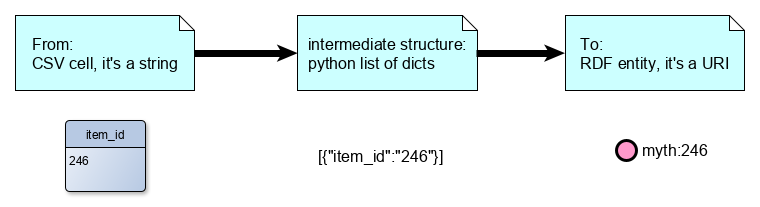



In [41]:
def add_simple_string(row, column_name):  # in this case this information will be represented as strings also in the rdf, no heavy processing needed
  if row[column_name] != "":
    row[column_name].strip()
    dictionary.update({column_name:row[column_name]})
  return dictionary

<b>Handling complex situation: one cell, multiple (chained) information. </b> 

In this case, due to the specificity of the case, we need to work case by case. Below we clean the case of <code>item_categories</code>.

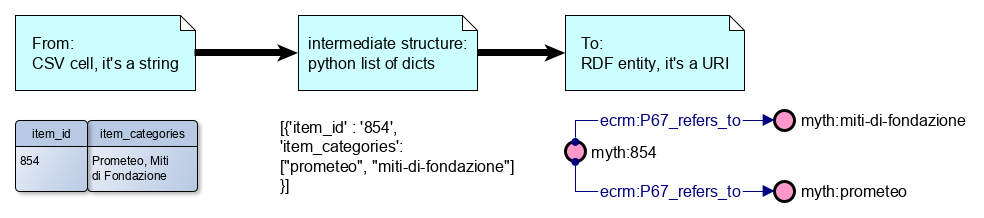

In [42]:
def categories_cleaning(categories_column):
  final = []
  categories_column.strip()
  cat_list = categories_column.split(',')
  for cat in cat_list:
    new_cat = cat.strip().replace(' ', '-').lower() # this is a simple case, use can use regex instead of this simple replace
    final.append(new_cat) 
  return final

As the late step in csv-cleaning process, we store all the new information into a new list of dictionaries, which contains all the information we need to transform them into rdf.

In [43]:
clean_data = [] # add everything to the clean_data (intermediate list of dicts)

for row in input_data:
  dictionary = {}
  add_simple_string(row, 'item_id')
  add_simple_string(row, 'item_title')
  dictionary.update({'categories':categories_cleaning(row['item_categories'])})
  clean_data.append(dictionary)
  
for row in clean_data: # And we check the result
  print(row)

{'item_id': '246', 'item_title': 'Lo sbarco di Enea in Italia', 'categories': ['enea-nella-penisola-italica']}
{'item_id': '854', 'item_title': 'Prometeo', 'categories': ['prometeo', 'miti-di-fondazione']}
{'item_id': '942', 'item_title': 'Flora in giardino', 'categories': ['flora', 'gli-dei']}
{'item_id': '3997', 'item_title': 'Pan e Siringa', 'categories': ['pan', 'gli-dei']}
{'item_id': '2149', 'item_title': 'Amore divino e profano', 'categories': ['eros', 'gli-dei']}


Now we can start translating rows and cells into nodes and archs. But first, we need to declare prefixes. 

In [44]:
g = Graph() # we create the graph to store triples

# declaring prefixes so that we can reuse them instead of writing down the whole URI anytime
efrbroo = Namespace("http://erlangen-crm.org/efrbroo/") 
myth = Namespace("https://w3id.org/mythlod/")
dct = Namespace("http://purl.org/dc/terms/")
ecrm = Namespace("http://erlangen-crm.org/current/")


In [45]:
g.bind('efrbroo', efrbroo) # we bind namespaces to the graph (g)
g.bind('myth', myth)
g.bind('dct', dct)
g.bind('ecrm', ecrm)

In [46]:
for row in clean_data:

  # we create first the URIRefs i will put in the triples 
  manifestation = URIRef(myth + row['item_id'])
  expression = URIRef(myth + 'expr' + row['item_id'])
  expr_creation = URIRef(myth + 'cre' + row['item_id'])

  # now we can create the triples reusing the schema we choose and the URIs we created
  # first we declare that an entity belongs to a class
  g.add((manifestation, RDF.type, efrbroo.F4_Manifestation_Singleton))
  g.add((expression, RDF.type, efrbroo.F2_Expression))
  g.add((expr_creation, RDF.type, efrbroo.F28_Expression_Creation))

  # we go on with adding triples to the graph but creating also relations between entities
  g.add((expr_creation, efrbroo.R17_created, expression))
  g.add((expr_creation, efrbroo.R18_created, manifestation))
  g.add((manifestation, dct.title, (Literal(row['item_title'], datatype=XSD.String))))
  
for s,p,o in g.triples((None, None, None)):
  print(s,p,o)

https://w3id.org/mythlod/expr854 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F2_Expression
https://w3id.org/mythlod/cre246 http://erlangen-crm.org/efrbroo/R18_created https://w3id.org/mythlod/246
https://w3id.org/mythlod/2149 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F4_Manifestation_Singleton
https://w3id.org/mythlod/246 http://purl.org/dc/terms/title Lo sbarco di Enea in Italia
https://w3id.org/mythlod/246 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F4_Manifestation_Singleton
https://w3id.org/mythlod/3997 http://purl.org/dc/terms/title Pan e Siringa
https://w3id.org/mythlod/3997 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F4_Manifestation_Singleton
https://w3id.org/mythlod/2149 http://purl.org/dc/terms/title Amore divino e profano
https://w3id.org/mythlod/expr246 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbro

In the cleaning phase we handled the <code>categories</code> data into the csv, in that case we stored a list of dictionaries into a single cell in our intermediate (cleaned) csv (which we called <code>clean_data</code>. Now we need to re-separate the entities in order to translate that list of dicts into triples. 

In [53]:
for row in clean_data:
  expression = URIRef(myth + 'expr' + row['item_id'])

  if row['categories']: # if there is a value in the csv cell
    for categ in row['categories']: # we iterate over the list
      # again, we create entities
      categ_uri = URIRef(myth + categ)

      # define them and make connections between them 
      g.add((categ_uri, RDF.type, ecrm.E1_CRM_Entity)) # we define the category 
      g.add((expression, ecrm.P67_refers_to, categ_uri)) # now we say that the item (expression) represents a category 

for s,p,o in g.triples((None,  ecrm.P67_refers_to, None)):   
  print(s,p,o)

https://w3id.org/mythlod/expr854 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/miti-di-fondazione
https://w3id.org/mythlod/expr3997 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/pan
https://w3id.org/mythlod/expr246 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/enea-nella-penisola-italica
https://w3id.org/mythlod/expr2149 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/gli-dei
https://w3id.org/mythlod/expr3997 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/gli-dei
https://w3id.org/mythlod/expr942 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/gli-dei
https://w3id.org/mythlod/expr854 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/prometeo
https://w3id.org/mythlod/expr2149 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/eros
https://w3id.org/mythlod/expr942 http://erlangen-crm.org/current/P67_refers

Now that the graph contains the triples we created, our dataset can be considered ready. We can save it. I choose to serialise and save it in turtle format because it is human-readable. 

In [54]:
output_path = "/content/drive/MyDrive/IDEHA /KO_mythLOD/example_rdf_turtle.ttl"

g.serialize(output_path, format='ttl')
print(g.serialize(format='ttl'))

b'@prefix dct: <http://purl.org/dc/terms/> .\n@prefix ecrm: <http://erlangen-crm.org/current/> .\n@prefix efrbroo: <http://erlangen-crm.org/efrbroo/> .\n@prefix myth: <https://w3id.org/mythlod/> .\n@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .\n\nmyth:cre2149 a efrbroo:F28_Expression_Creation ;\n    efrbroo:R17_created myth:expr2149 ;\n    efrbroo:R18_created myth:2149 .\n\nmyth:cre246 a efrbroo:F28_Expression_Creation ;\n    efrbroo:R17_created myth:expr246 ;\n    efrbroo:R18_created myth:246 .\n\nmyth:cre3997 a efrbroo:F28_Expression_Creation ;\n    efrbroo:R17_created myth:expr3997 ;\n    efrbroo:R18_created myth:3997 .\n\nmyth:cre854 a efrbroo:F28_Expression_Creation ;\n    efrbroo:R17_created myth:expr854 ;\n    efrbroo:R18_created myth:854 .\n\nmyth:cre942 a efrbroo:F28_Expression_Creation ;\n    efrbroo:R17_created myth:expr942 ;\n    efrbroo:R18_created myth:942 .\n\nmyth:2149 a efrbroo:F4_Manifestation_Singleton ;\n    dct:title "Amore divino e profano"^^xsd:String .\n\nm

<b>We can do exaclty the same thing but using quads instead of triples.</b> 

Triple structure: subject, predicate, object
Quads structure: subject, predicate, object, context

Context is always an URI and it acts like a sort of "container" for the triple. In this way you can specify that a triple has some meaning in a particular context. It is very useful when you express subjective information (as in mythLOD case). For example with quads you can express something like:

1) <code>myth:expr854 ecrm:P67_refers_to myth:enea, myth:valentina_opinion1</code>

2) <code>myth:expr854 ecrm:P67_refers_to myth:didone, myth:bruno_opinion1</code>

This means that me and Bruno are expressing the interpretation over the artifact, but mantaining the provenance information.  

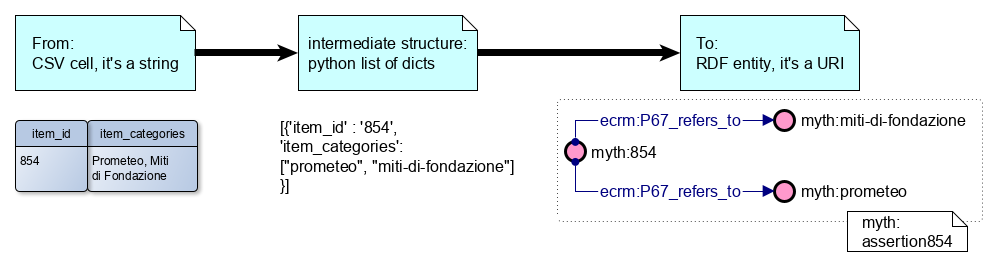

We do exactly what we did with triple but using 4 elements, instead of 3. 

First of all, again we create the graph, that in this case is called <code>ConjunctiveGraph()</code> instad of simply <code>Graph()</code>

In [55]:
from rdflib import ConjunctiveGraph

gc = ConjunctiveGraph () 

# now we bind the namespaces to gc
gc.bind('efrbroo', efrbroo) # we bind namespaces to the graph
gc.bind('myth', myth)
gc.bind('dct', dct)
gc.bind('ecrm', ecrm)

In [56]:
 for row in clean_data:

  # we create first the URIRefs i will put in the triples 
  manifestation = URIRef(myth + row['item_id'])
  expression = URIRef(myth + 'expr' + row['item_id'])
  expr_creation = URIRef(myth + 'cre' + row['item_id'])
  factual_data_bag = URIRef(myth + 'factual_data_bag')

  # now we can create the triples reusing the schema we choose and the URIs we created
  # first we declare that an entity belongs to a class
  gc.add((manifestation, RDF.type, efrbroo.F4_Manifestation_Singleton, factual_data_bag))
  gc.add((expression, RDF.type, efrbroo.F2_Expression, factual_data_bag))
  gc.add((expr_creation, RDF.type, efrbroo.F28_Expression_Creation, factual_data_bag))

  # we go on with adding triples to the graph but creating also relations between entities
  gc.add((expr_creation, efrbroo.R17_created, expression, factual_data_bag))
  gc.add((expr_creation, efrbroo.R18_created, manifestation, factual_data_bag))
  gc.add((manifestation, dct.title, Literal(row['item_title'], datatype=XSD.String), factual_data_bag))
  
for s,p,o,c in gc.quads((None, None, None, None)):
  print(s,p,o,c)

https://w3id.org/mythlod/cre3997 http://erlangen-crm.org/efrbroo/R18_created https://w3id.org/mythlod/3997 <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
https://w3id.org/mythlod/cre942 http://erlangen-crm.org/efrbroo/R18_created https://w3id.org/mythlod/942 <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
https://w3id.org/mythlod/cre3997 http://erlangen-crm.org/efrbroo/R17_created https://w3id.org/mythlod/expr3997 <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
https://w3id.org/mythlod/cre2149 http://erlangen-crm.org/efrbroo/R17_created https://w3id.org/mythlod/expr2149 <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
https://w3id.org/mythlod/cre246 http://erlangen-crm.org/efrbroo/R17_created https://w3id.org/mythlod/expr246 <https://

In [51]:
for row in clean_data:

  if row['categories']:
    for categ in row['categories']: # we iterate over the list
      # again, we create entities
      categ_uri = URIRef(myth + categ)
      assertion_bag = URIRef(myth + 'assertion' + row['item_id'])

      # define them and make connections between them 
      gc.add((categ_uri, RDF.type, ecrm.E1_CRM_Entity, factual_data_bag)) # we define the category, this triple is not contestable 
      gc.add((expression, ecrm.P67_refers_to, categ_uri, assertion_bag)) # now we say that the item (expression) represents a category, this is deemed to be contestable

for s,p,o,c in gc.quads((None, None, None, None)):   
  print(s,p,o,c)

https://w3id.org/mythlod/cre246 http://erlangen-crm.org/efrbroo/R18_created https://w3id.org/mythlod/246 <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
https://w3id.org/mythlod/cre3997 http://erlangen-crm.org/efrbroo/R18_created https://w3id.org/mythlod/3997 <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
https://w3id.org/mythlod/expr2149 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/pan <https://w3id.org/mythlod/assertion3997> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
https://w3id.org/mythlod/expr2149 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F2_Expression <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'IOMemory'].
https://w3id.org/mythlod/cre942 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/ef

In [52]:
output_path = "/content/drive/MyDrive/IDEHA /KO_mythLOD/example_rdf_trig.trig"

gc.serialize(output_path, format='trig')
print(gc.serialize(format='trig'))

b'@prefix dct: <http://purl.org/dc/terms/> .\n@prefix ecrm: <http://erlangen-crm.org/current/> .\n@prefix efrbroo: <http://erlangen-crm.org/efrbroo/> .\n@prefix myth: <https://w3id.org/mythlod/> .\n@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .\n\nmyth:assertion2149 {\n    myth:expr2149 ecrm:P67_refers_to myth:eros,\n            myth:gli-dei .\n}\n\nmyth:assertion942 {\n    myth:expr2149 ecrm:P67_refers_to myth:flora,\n            myth:gli-dei .\n}\n\nmyth:assertion246 {\n    myth:expr2149 ecrm:P67_refers_to myth:enea-nella-penisola-italica .\n}\n\nmyth:assertion3997 {\n    myth:expr2149 ecrm:P67_refers_to myth:gli-dei,\n            myth:pan .\n}\n\nmyth:assertion854 {\n    myth:expr2149 ecrm:P67_refers_to myth:miti-di-fondazione,\n            myth:prometeo .\n}\n\nmyth:factual_data_bag {\n    myth:cre2149 a efrbroo:F28_Expression_Creation ;\n        efrbroo:R17_created myth:expr2149 ;\n        efrbroo:R18_created myth:2149 .\n\n    myth:cre246 a efrbroo:F28_Expression_Creation ;\n

Now, in the repository (github or drive as you prefer) you can look at the difference between the two datasets. What do you think?